In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [4]:
end_date = dt.date(2023, 3, 18)
start_date = end_date - dt.timedelta(days=8*365)
eur_usd = yf.download('EURUSD=X', start=start_date, end=end_date)

cny_usd= yf.download('CNYUSD=X', start=start_date, end=end_date)

gbp_usd = yf.download('GBPUSD=X', start=start_date, end=end_date)

cad_usd = yf.download('CADUSD=X', start=start_date, end=end_date)

rub_usd = yf.download('RUBUSD=X', start=start_date, end=end_date)

jpy_usd = yf.download('JPYUSD=X', start=start_date, end=end_date)

aud_usd = yf.download('AUDUSD=X', start=start_date, end=end_date)

chf_usd = yf.download('CHFUSD=X', start=start_date, end=end_date)

krw_usd = yf.download('KRWUSD=X', start=start_date, end=end_date)

hkd_usd = yf.download('HKDUSD=X', start=start_date, end=end_date)

kwd_usd = yf.download('KWDUSD=X', start=start_date, end=end_date)

bhd_usd = yf.download('BHDUSD=X', start=start_date, end=end_date)

omr_usd = yf.download('OMRUSD=X', start=start_date, end=end_date)

kyd_usd = yf.download('KYDUSD=X', start=start_date, end=end_date)

bsd_usd = yf.download('BSDUSD=X', start=start_date, end=end_date)

daily_return = pd.DataFrame()
daily_return["EUR/USD"] = eur_usd['Close'].pct_change()
daily_return["CNY/USD"] = cny_usd['Close'].pct_change()
daily_return["GBP/USD"] = gbp_usd['Close'].pct_change()
daily_return["CAD/USD"] = cad_usd['Close'].pct_change()
daily_return["RUB/USD"] = rub_usd['Close'].pct_change()
daily_return["JPY/USD"] = jpy_usd['Close'].pct_change()
daily_return["AUD/USD"] = aud_usd['Close'].pct_change()
daily_return["CHF/USD"] = chf_usd['Close'].pct_change()
daily_return["KRW/USD"] = krw_usd['Close'].pct_change()
daily_return["HKD/USD"] = hkd_usd['Close'].pct_change()
daily_return["KWD/USD"] = kwd_usd['Close'].pct_change()
daily_return["BHD/USD"] = bhd_usd['Close'].pct_change()
daily_return["OMR/USD"] = omr_usd['Close'].pct_change()
daily_return["KYD/USD"] = kyd_usd['Close'].pct_change()
daily_return["BSD/USD"] = bsd_usd['Close'].pct_change()

log_return = pd.DataFrame()
log_return["EUR/USD"] = np.log(eur_usd['Close'] / eur_usd['Close'].shift(1))
log_return["CNY/USD"] = np.log(cny_usd['Close'] / cny_usd['Close'].shift(1))
log_return["GBP/USD"] = np.log(gbp_usd['Close'] / gbp_usd['Close'].shift(1))
log_return["CAD/USD"] = np.log(cad_usd['Close'] / cad_usd['Close'].shift(1))
log_return["RUB/USD"] = np.log(rub_usd['Close'] / rub_usd['Close'].shift(1))
log_return["JPY/USD"] = np.log(jpy_usd['Close'] / jpy_usd['Close'].shift(1))
log_return["AUD/USD"] = np.log(aud_usd['Close'] / aud_usd['Close'].shift(1))
log_return["CHF/USD"] = np.log(chf_usd['Close'] / chf_usd['Close'].shift(1))
log_return["KRW/USD"] = np.log(krw_usd['Close'] / krw_usd['Close'].shift(1))
log_return["HKD/USD"] = np.log(hkd_usd['Close'] / hkd_usd['Close'].shift(1))
log_return["KWD/USD"] = np.log(kwd_usd['Close'] / kwd_usd['Close'].shift(1))
log_return["BHD/USD"] = np.log(bhd_usd['Close'] / bhd_usd['Close'].shift(1))
log_return["OMR/USD"] = np.log(omr_usd['Close'] / omr_usd['Close'].shift(1))
log_return["KYD/USD"] = np.log(kyd_usd['Close'] / kyd_usd['Close'].shift(1))
log_return["BSD/USD"] = np.log(bsd_usd['Close'] / bsd_usd['Close'].shift(1))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
log_return

,EUR/USD,CNY/USD,GBP/USD,CAD/USD,RUB/USD,JPY/USD,AUD/USD,CHF/USD,KRW/USD,HKD/USD,KWD/USD,BHD/USD,OMR/USD,KYD/USD,BSD/USD
Date,,,,,,,,,,,,,,,
2015-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-23,0.014670,-0.001615,0.012223,0.009517,0.013415,0.006105,0.016291,0.012444,0.006741,0.000120,0.001939,0.000107,-0.001225,-0.004975,0.003504
2015-03-24,0.010875,-0.001452,0.000583,0.004757,0.008988,0.002310,0.011666,0.011834,0.007539,0.000188,0.000100,-0.000267,0.000964,0.013988,-0.001723
2015-03-25,-0.003933,0.001565,-0.007923,0.000959,0.016575,-0.000342,-0.001574,0.006679,0.001596,0.000115,-0.000937,0.000160,-0.000078,0.000000,0.000000
2015-03-26,0.005345,-0.000920,0.002927,-0.001438,0.005862,0.002282,-0.004159,-0.000844,0.002445,-0.000004,0.000803,-0.000694,-0.000860,-0.009421,-0.000272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13,0.009305,0.008422,0.013069,0.004870,-0.004606,0.010429,0.006533,0.015611,0.004544,0.000263,0.001272,-0.000329,-0.000164,0.005178,0.005323
2023-03-14,0.003864,0.008815,0.007590,0.002080,0.008571,0.013921,0.003761,0.006455,0.017707,0.000372,0.001404,0.000281,-0.000867,-0.005937,-0.005851
2023-03-15,0.000247,-0.003777,-0.001581,0.003377,-0.002645,-0.009592,0.004480,-0.002199,-0.006305,-0.000433,-0.000817,-0.000075,0.001321,0.001192,0.001275


In [6]:
eur_usd = eur_usd[['Close']].rename(columns={'Close': 'EUR/USD'})
cny_usd = cny_usd[['Close']].rename(columns={'Close': 'CNY/USD'})
gbp_usd = gbp_usd[['Close']].rename(columns={'Close': 'GBP/USD'})
cad_usd = cad_usd[['Close']].rename(columns={'Close': 'CAD/USD'})
rub_usd = rub_usd[['Close']].rename(columns={'Close': 'RUB/USD'})
jpy_usd = jpy_usd[['Close']].rename(columns={'Close': 'JPY/USD'})
aud_usd = aud_usd[['Close']].rename(columns={'Close': 'AUD/USD'})
chf_usd = chf_usd[['Close']].rename(columns={'Close': 'CHF/USD'})
krw_usd = krw_usd[['Close']].rename(columns={'Close': 'KRW/USD'})
hkd_usd = hkd_usd[['Close']].rename(columns={'Close': 'HKD/USD'})
kwd_usd = kwd_usd[['Close']].rename(columns={'Close': 'KWD/USD'})
bhd_usd = bhd_usd[['Close']].rename(columns={'Close': 'BHD/USD'})
omr_usd = omr_usd[['Close']].rename(columns={'Close': 'OMR/USD'})
kyd_usd = kyd_usd[['Close']].rename(columns={'Close': 'KYD/USD'})
bsd_usd = bsd_usd[['Close']].rename(columns={'Close': 'BSD/USD'})

In [7]:
exchange_rates = pd.concat([eur_usd, cny_usd, gbp_usd, cad_usd, rub_usd, jpy_usd, aud_usd, chf_usd, krw_usd, hkd_usd, kwd_usd, bhd_usd, omr_usd, kyd_usd, bsd_usd], axis=1)
exchange_rates

,EUR/USD,CNY/USD,GBP/USD,CAD/USD,RUB/USD,JPY/USD,AUD/USD,CHF/USD,KRW/USD,HKD/USD,KWD/USD,BHD/USD,OMR/USD,KYD/USD,BSD/USD
Date,,,,,,,,,,,,,,,
2015-03-20,1.066894,0.161655,1.476167,0.787340,0.016657,0.008281,0.765814,1.010366,0.000893,0.128904,3.339456,2.672225,2.607222,1.237593,1.005096
2015-03-23,1.082661,0.161394,1.494322,0.794868,0.016882,0.008331,0.778392,1.023018,0.000899,0.128919,3.345936,2.672511,2.604031,1.231451,1.008624
2015-03-24,1.094499,0.161160,1.495193,0.798658,0.017034,0.008351,0.787526,1.035197,0.000906,0.128943,3.346272,2.671797,2.606542,1.248798,1.006887
2015-03-25,1.090203,0.161413,1.483393,0.799424,0.017319,0.008348,0.786287,1.042133,0.000908,0.128958,3.343140,2.672225,2.606339,1.248798,1.006887
2015-03-26,1.096047,0.161264,1.487741,0.798276,0.017421,0.008367,0.783024,1.041255,0.000910,0.128958,3.345824,2.670370,2.604099,1.237088,1.006613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13,1.068365,0.144818,1.207934,0.726544,0.013129,0.007409,0.663420,1.088850,0.000758,0.127429,3.263069,2.671732,2.606291,1.233797,1.011646
2023-03-14,1.072501,0.146101,1.217137,0.728056,0.013242,0.007512,0.665920,1.095901,0.000771,0.127476,3.267653,2.672482,2.604031,1.226494,1.005744
2023-03-15,1.072766,0.145550,1.215214,0.730519,0.013207,0.007441,0.668910,1.093494,0.000767,0.127421,3.264987,2.672282,2.607474,1.227957,1.007027


In [8]:
def split_data(data, split_ratio=0.8):
    split_index = int(len(data) * split_ratio)
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]
    return train_data, test_data

def fit_arima_garch(data, arima_order=(1, 1, 1), garch_order=(1, 1)):
    # Fit ARIMA model
    arima_model = sm.tsa.arima.ARIMA(train_data, order=(2,1,2))
    arima_res = arima_model.fit()

    # Obtain ARIMA model residuals
    arima_residuals = arima_res.resid

    # Fit GARCH model on ARIMA residuals
    garch_model = arch_model(arima_residuals, vol='Garch', p=garch_order[0], q=garch_order[1])
    garch_res = garch_model.fit(disp='off')

    return arima_res, garch_res


def predict_arima_garch(arima_res, garch_res, steps=1):
    # Forecast ARIMA
    arima_forecast = arima_res.forecast(steps=steps)

    # Forecast GARCH
    garch_forecast = garch_res.forecast(start=len(arima_res.resid) - 1, horizon=steps)

    # Get GARCH conditional variances
    garch_cond_var = garch_forecast.variance.values[-1, :]

    # Combine ARIMA forecasts and GARCH conditional variances
    combined_forecast = arima_forecast + np.sqrt(garch_cond_var)

    return combined_forecast

#     train_data.reset_index(inplace=True)
#     test_data.reset_index(inplace=True)


def arima_garch_trading_strategy(commodity_data, arima_order=(1, 1, 1), garch_order=(1, 1)):
    long_positions = {commodity: [] for commodity in commodity_data.columns[1:]}
    short_positions = {commodity: [] for commodity in commodity_data.columns[1:]}

    # Split the data into training and testing sets
#     train_data, test_data = split_data(commodity_data)
#     train_data.reset_index(inplace=True)
#     test_data.reset_index(inplace=True)
    for commodity in commodity_data.columns[1:]:
        # Fit ARIMA-GARCH models on the training data
        train_data, test_data = split_data(commodity_data[commodity])
        
        arima_res, garch_res = fit_arima_garch(train_data, arima_order, garch_order)

        # Generate forecasts for the test data
        steps = len(test_data)
        forecasts = predict_arima_garch(arima_res, garch_res, steps)

        # Implement trading strategy
        for i in range(steps):
            if forecasts[i] > test_data[i]:
                long_positions[commodity].append(test_data['Date'].iloc[i])
            else:
                short_positions[commodity].append(test_data['Date'].iloc[i])

    return long_positions, short_positions



In [9]:
train_data, test_data = split_data(exchange_rates.copy()['GBP/USD'].tail(-1))
arima_res, garch_res = fit_arima_garch(train_data, arima_order=(1, 1, 1), garch_order=(1, 1))
combined_forecast = predict_arima_garch(arima_res, garch_res, steps = 30)
combined_forecast

1665    1.543473
1666    1.537121
1667    1.532574
1668    1.528919
1669    1.526343
1670    1.524293
1671    1.522864
1672    1.521732
1673    1.520949
1674    1.520329
1675    1.519904
1676    1.519567
1677    1.519337
1678    1.519153
1679    1.519029
1680    1.518930
1681    1.518863
1682    1.518809
1683    1.518773
1684    1.518744
1685    1.518724
1686    1.518709
1687    1.518698
1688    1.518690
1689    1.518684
1690    1.518679
1691    1.518676
1692    1.518674
1693    1.518672
1694    1.518671
Name: predicted_mean, dtype: float64

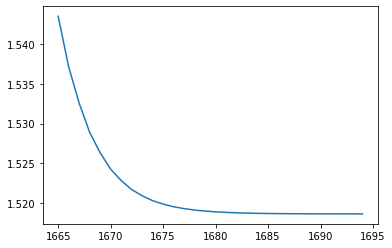

In [10]:
# arima_garch_trading_strategy(commodity_data = exchange_rates, arima_order=(1, 1, 1), garch_order=(1, 1))
# plt.plot(test_data)
plt.plot(combined_forecast)
